In [1]:
import torch
from example_models import MNIST_model, CIFAR_model, show_image, show_mei
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import sys
sys.path.append('..')

# Build and train your models

In [2]:
model = MNIST_model #CIFAR_model
load = True

model1 = model(name="model1", device=device, load=load)
model2 = model(name="model2", device=device, load=load)

if not load:
    model1.train(epochs=10)
    model2.train(epochs=10)
model1.eval()
model2.eval()
model1.save()
model2.save()

Loading model1...
Loading model2...
Test Accuracy: 96.88%
Test Accuracy: 97.08%


# Import and instantiate MEI

In [3]:
import src.mei as mei
Mei = mei.MEI(models=[model1, model2])

# Generate *most exciting input*

100%|██████████| 1000/1000 [00:00<00:00, 8132.45it/s]


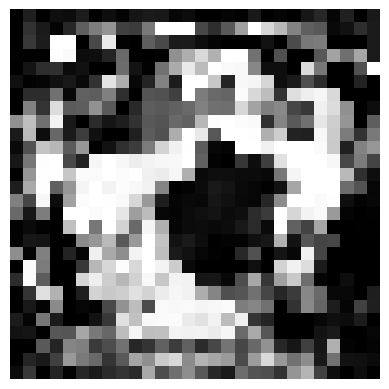

Activation:  1.0


In [6]:
meip = Mei.generate(0)
show_mei(meip)

# Generate gradient receptive field

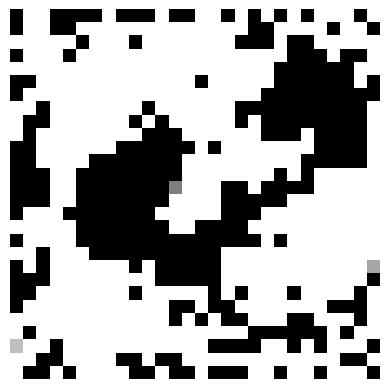

Activation:  1.0


In [12]:
gradrf = Mei.gradient_rf(3)
show_mei(gradrf)

# Find most excitatory samples from dataset

100%|██████████| 60000/60000 [00:09<00:00, 6186.37it/s]


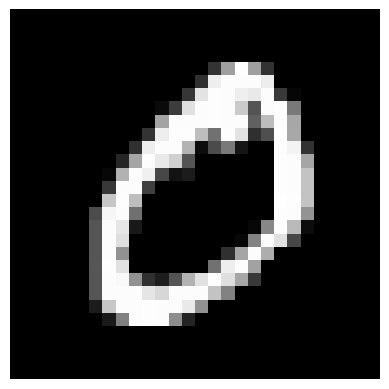

In [7]:
meip_best_match = meip.best_match(model1.train_loader)
show_image(meip_best_match[1][0][0])

# Compare original and *masked/shifted* responses

100%|██████████| 1/1 [00:00<00:00, 325.92it/s]

original response:  1.0
masked response:  0.9979651
shifted response:  0.0020843507
original image: 


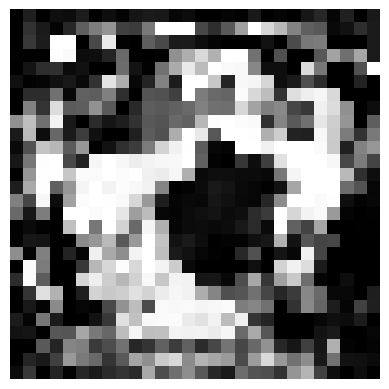

masked image: 


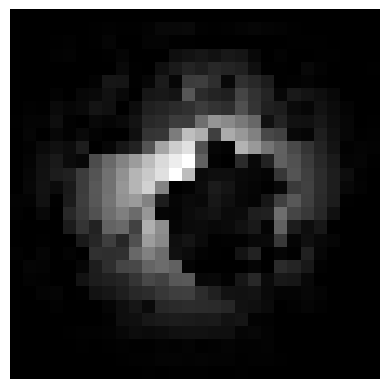

shifted image: 


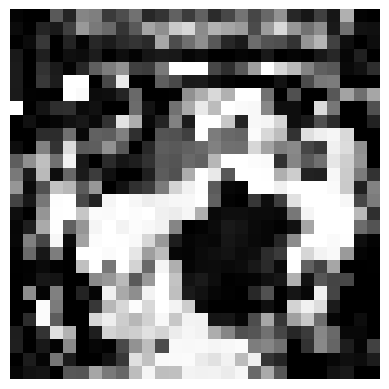

In [7]:
orig_resp, masked_resp, masked_image = meip.masked_responses(factor=5)
shifted_resp, shifted_image = meip.shifted_response(x_shift=1, y_shift=3)
print("original response: ", orig_resp)
print("masked response: ", masked_resp)
print("shifted response: ", shifted_resp)

print("original image: ")
show_image(meip.image)

print("masked image: ")
show_image(masked_image)

print("shifted image: ")
show_image(shifted_image)

# Create Gabor stimuli and find most excitatory ones

Creating gabors


72800it [01:35, 759.20it/s]


Evaluating gabors


72800it [00:06, 11610.22it/s]


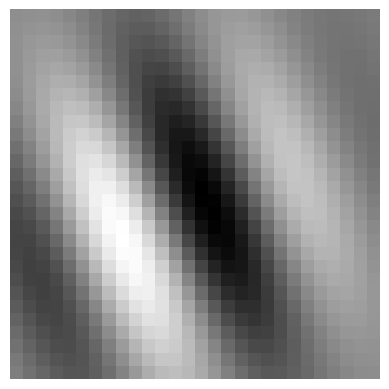

Activation:  1.0


In [8]:
gabor = mei.Gabor(models=[model1, model2])
gabor.set_ranges(height=[28], width=[28])
best_gabor = gabor.best_gabor(0)
show_mei(best_gabor)

# Find optimal Gabor stimuli

100%|██████████| 5/5 [00:26<00:00,  5.27s/it]


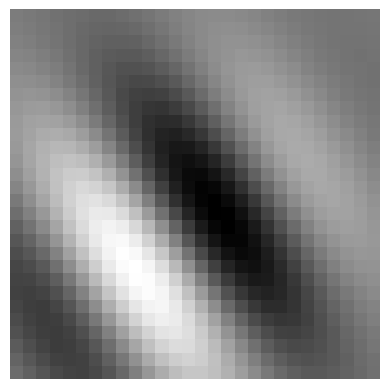

Activation:  1.0


In [9]:
optimal_gabor = gabor.optimal_gabor(0)
show_mei(optimal_gabor)

# Compute spatial frequency

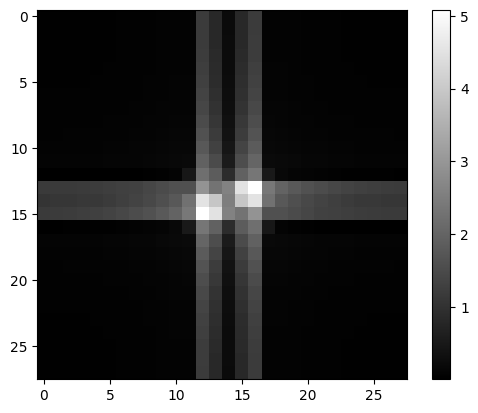

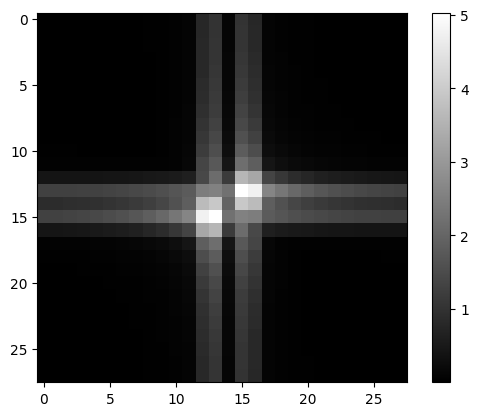

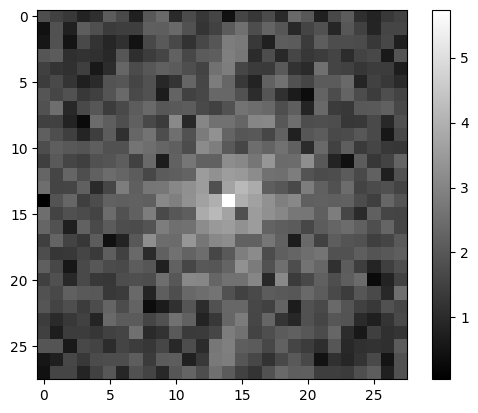

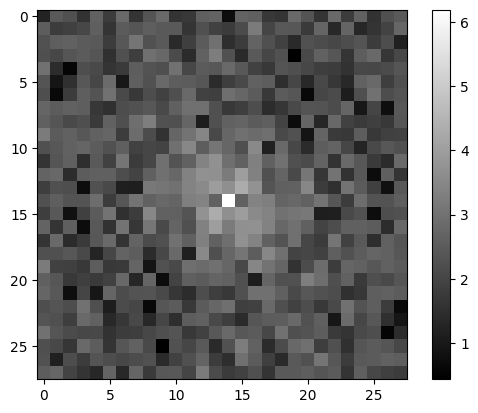

In [13]:
freq_cols_best_gabor, freq_rows_best_gabor, magnitude_spectrum_best_gabor = best_gabor.spatial_frequency()

freq_cols_optimal_gabor, freq_rows_optimal_gabor, magnitude_spectrum_optimal_gabor = optimal_gabor.spatial_frequency()

freq_cols_mei, freq_rows_mei, magnitude_spectrum_mei = meip.spatial_frequency()

freq_cols_gradrf, freq_rows_gradrf, magnitude_spectrum_gradrf = gradrf.spatial_frequency()

# Dev tools

In [6]:
import importlib
importlib.reload(mei)

<module 'src.mei' from '/Users/laszlofreund/code/ai/mei/torch/mei/src/mei.py'>